# Assignment 1: Let the Tensors Flow - Hannan Mahadik


## Imports

In [ ]:
from google.colab import drive; 
drive.mount('/content/drive/', force_remount=True)

import os
os.chdir("/content/drive/MyDrive/ColabNotebooks/Intro to Deep Learning")

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from datasets import MNISTDataset

Mounted at /content/drive/


## Load MNIST Dataset 

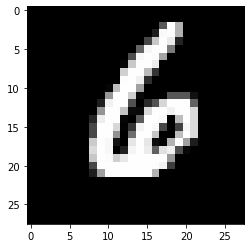

6


In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# we can look at any of the images and the corresponding labels
# say, image no. 155
plt.imshow(train_images[155], cmap="Greys_r")
plt.show()
print(train_labels[155])

# images are "flattened" into vectors
data = MNISTDataset(train_images.reshape([-1, 28*28]), train_labels, 
                    test_images.reshape([-1, 28*28]), test_labels,
                    batch_size=128)

## Visualization - Flattening

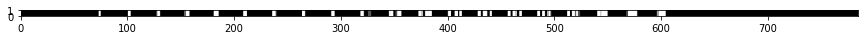

In [ ]:
# here is an attempt at illustrating what flattening looks like
reshaped = train_images[155].reshape((1, 28*28))
plt.figure(figsize=(15, 0.1))
plt.pcolormesh(reshaped, cmap="Greys_r")
plt.show()

## Convert Images to NP Arrays

In [ ]:
train_images = train_images.astype(np.float32) / 255
test_images = test_images.astype(np.float32) / 255

## Parameter Initialization


In [ ]:
# define the linear model
# weight dimensions are completely determined by input/output dimensions
W = tf.Variable(np.zeros([28*28, 10]).astype(np.float32))
b = tf.Variable(np.zeros(10, dtype=np.float32))

def model(inputs):
    return tf.matmul(inputs, W) + b

# NOTE
# the ONLY thing that you should have to change for a working MLP is to
# - add more variables
# - adapt the model function (don't forget activation functions)
# - add the new variables in the gradient call/update below

# parameters for the training process
# this already offers potential for experimentation
# - how many steps do we actually need to reach acceptable performance?
# - what if we train for some absurd number of steps?
# - what happens if we increase/decrease the learning rate?
# - do learning rate and number of steps interact?
# - ...
train_steps = 2000
learning_rate = 0.1

## Training (Original Model)

In [ ]:
# training loop
for step in range(train_steps+1):
    image_batch, label_batch = data.next_batch()

    with tf.GradientTape() as tape:
        logits = model(image_batch)
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=label_batch))
        
    grads = tape.gradient(xent, [W, b])
    W.assign_sub(learning_rate * grads[0])
    b.assign_sub(learning_rate * grads[1])
    
    # every so often we print loss/accuracy
    if not step % 100:
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(tf.equal(preds, label_batch),
                             tf.float32))
        print("Step {}. Batch loss: {} Batch accuracy: {}".format(step+1, xent, acc))



## Deep Model

In [ ]:
# Module - A named container for tf.Variables
class mlp(tf.Module):
  
  def __init__(self, units_per_layer, activation_function, name=None):

    # initialization
    self.activation_function = activation_function
    self.layers = len(units_per_layer) 
    self.params = {}

    # weight and bias initialization for the hidden layers
    for layer in range(1, self.layers):

      # Input of hidden layer 2 = output of hidden layer 1
      input_size = units_per_layer[layer - 1] 
      output_size = units_per_layer[layer] 

      # Weights cannot be zero => Initialized with values close to zero
      weights = "w{}".format(layer)
      self.params[weights] = tf.Variable(
          np.random.randn(input_size, output_size).astype(np.float32) * 0.01, 
          name = weights
      )

      # Bias initialized as zero (same as 'shallow' model) 
      bias = "b{}".format(layer)
      self.params[bias] = tf.Variable(
          np.zeros(output_size, dtype = np.float32), 
          name = bias
      )


  def __call__(self, x):

    logits = self.logits(x)

    # Logits are 'pre-softmax values' => apply softmax activation function
    activation_function = tf.nn.softmax(logits, axis = 1)

    return activation_function


  def logits(self, x):
    activation = x

    # Assign each of the hidden layers with an input and activation function
    for layer in range(1, self.layers-1):
      weights, bias = "w{}".format(layer), "b{}".format(layer)
      z = activation @ self.params[weights] + self.params[bias]
      activation = self.activation_function(z)

    # Output layer 
    weights, bias = "w{}".format(self.layers-1), "b{}".format(self.layers-1)
    logits = activation @ self.params[weights] + self.params[bias]

    return logits

## Model Specification

In [ ]:
# Function for easy customization of number of units, layers, and activation function
def results(x):

  no_of_units = x['units']
  no_of_layers = x['layers']
  
  model = [28*28] + [no_of_units for _ in range(no_of_layers)] + [10]

  result = train(mlp(model, x['activation_function']), data, 
                 training_steps = x['train_steps'], 
                 learning_rate = x['learning_rate'])

## Training (MLP)

In [ ]:
def train(model, data, training_steps, learning_rate):

  for step in range(1, training_steps + 1):
    image_batch, label_batch = data.next_batch()

    with tf.GradientTape() as tape:
      logits = model.logits(image_batch)
      xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
          logits=logits, labels=label_batch))

    grads = tape.gradient(xent, model.variables)

    # Perform one step of gradient descent
    for (variable, gradient) in zip(model.variables, grads):
      variable.assign_sub(learning_rate * gradient)
     
    # every so often we print loss/accuracy 
    if not step % 100:
      preds = tf.argmax(logits, axis=1, output_type=tf.int32)
      acc = tf.reduce_mean(tf.cast(tf.equal(preds, label_batch),tf.float32))

      print("Step {}. Batch loss: {} Batch accuracy: {}".format(step+1, xent, acc))

# Test

## Test (Original Model)

In [ ]:
# test_preds = tf.argmax(tf.matmul(data.test_data, W) + b, axis=1,
#                        output_type=tf.int32)
# acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, data.test_labels),
#                              tf.float32))
# print(acc)

## Test (Deep Model)

In [ ]:
x = {'layers':1, 'units':100, 'activation_function':tf.nn.relu,'train_steps':2000, 'learning_rate':0.1}
results(x)

Step 101. Batch loss: 1.0678164958953857 Batch accuracy: 0.6953125
Step 201. Batch loss: 0.6205866932868958 Batch accuracy: 0.8671875
Step 301. Batch loss: 0.412026584148407 Batch accuracy: 0.8984375
Step 401. Batch loss: 0.4178839921951294 Batch accuracy: 0.8984375
Starting new epoch...
Step 501. Batch loss: 0.36517366766929626 Batch accuracy: 0.8984375
Step 601. Batch loss: 0.36928361654281616 Batch accuracy: 0.90625
Step 701. Batch loss: 0.3823903203010559 Batch accuracy: 0.8828125
Step 801. Batch loss: 0.26622289419174194 Batch accuracy: 0.9375
Step 901. Batch loss: 0.1436774730682373 Batch accuracy: 0.9609375
Starting new epoch...
Step 1001. Batch loss: 0.2418626844882965 Batch accuracy: 0.9375
Step 1101. Batch loss: 0.24137619137763977 Batch accuracy: 0.9453125
Step 1201. Batch loss: 0.2740941047668457 Batch accuracy: 0.9140625
Step 1301. Batch loss: 0.27896934747695923 Batch accuracy: 0.9375
Step 1401. Batch loss: 0.2778792977333069 Batch accuracy: 0.9140625
Starting new epoch..

# Bonus 

## Load Fashion Dataset

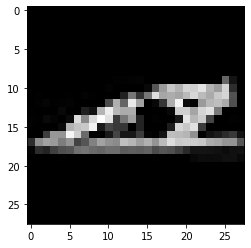

5


In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# we can look at any of the images and the corresponding labels
# say, image no. 155
plt.imshow(train_images[155], cmap="Greys_r")
plt.show()
print(train_labels[155])

# images are "flattened" into vectors
data = MNISTDataset(train_images.reshape([-1, 28*28]), train_labels, 
                    test_images.reshape([-1, 28*28]), test_labels,
                    batch_size=128)

## Convert to NP Arrays

In [ ]:
train_images = train_images.astype(np.float32) / 255
test_images = test_images.astype(np.float32) / 255

## Test Model

In [ ]:
x = {'layers':1, 'units':100, 'activation_function':tf.nn.tanh,'train_steps':2000, 'learning_rate':0.15}
results(x)

Step 101. Batch loss: 0.7347116470336914 Batch accuracy: 0.6796875
Step 201. Batch loss: 0.6373168230056763 Batch accuracy: 0.7578125
Step 301. Batch loss: 0.5396754741668701 Batch accuracy: 0.8203125
Starting new epoch...
Step 401. Batch loss: 0.4082949161529541 Batch accuracy: 0.859375
Step 501. Batch loss: 0.4792635440826416 Batch accuracy: 0.8359375
Step 601. Batch loss: 0.5284992456436157 Batch accuracy: 0.78125
Step 701. Batch loss: 0.5093953609466553 Batch accuracy: 0.8125
Step 801. Batch loss: 0.411000519990921 Batch accuracy: 0.890625
Starting new epoch...
Step 901. Batch loss: 0.34168434143066406 Batch accuracy: 0.8828125
Step 1001. Batch loss: 0.5156997442245483 Batch accuracy: 0.8203125
Step 1101. Batch loss: 0.45732298493385315 Batch accuracy: 0.8359375
Step 1201. Batch loss: 0.36308881640434265 Batch accuracy: 0.8671875
Step 1301. Batch loss: 0.436737060546875 Batch accuracy: 0.859375
Starting new epoch...
Step 1401. Batch loss: 0.34674710035324097 Batch accuracy: 0.86718

## Accuracy using different activation functions



1.   Sigmoid = ~82%
2.   Tanh = ~84%
3.   ReLu = ~85%



## Accuracy using different number of hidden layers

1.   1 hidden layer = ~82%
2.   2 hidden layers = ~30%
3.   3 hidden layers = ~5%



## Accuracy using different number of units in hidden layer

1.   10 hidden units = ~71%
2.   50 hidden units = ~79%
3.   100 hidden units = ~82%

